# Sentinel 1 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:**
[sentinel1_ghana_monthly](https://explorer.digitalearth.africa/sentinel1_ghana_monthly)
<!-- [Level-1 Single Look Complex and Ground Range Detected](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/product-types-processing-levels/level-1), -->

## Background

The [Sentinel-1](https://en.wikipedia.org/wiki/Sentinel-1) mission is composed of a constellation of two Synthetic Aperture Radar (SAR) satellites, Sentinel-1A and Sentinel-1B, sharing the same orbital plane. Sentinel-1 provides dual polarisation capability, very short revisit times, and rapid product delivery.

SAR data has the advantage of operating at wavelengths not impeded by cloud cover or a lack of illumination and can acquire data over a site during the day or night, and under most weather conditions. The Sentinel-1 mission is the European Radar Observatory for the Copernicus joint initiative of the European Commission (EC) and the European Space Agency (ESA) that can offer reliable and repeated wide area monitoring with its SAR instrument. 

Sentinel-1 products will benefit users interested in agriculture, forestry and land cover classification. The rapid data dissemination and short revisit cycles of Sentinel-1 together with its interferometric capabilities will also benefit emergency response users, such as the United Nations [International Charter on Space and Major Disasters](https://disasterscharter.org/web/guest/home;jsessionid=83C5354659FD4EFBE0A8D388BBA5B56F.jvm1), in emergency situations such as floods, earthquakes, volcanic eruptions and landslides.

Sentinel-1A was launched on 3 April 2014 and Sentinel-1B followed on 25 April 2016. Two other spacecraft (Sentinel-1C and Sentinel-1D) are planned to replace the first two satellites at the end of their operational lifespan. For more information on the Sentinel-1 platforms and applications, check out the [European Space Agency](https://sentinel.esa.int/web/sentinel/missions/sentinel-1) website.

The Normalized Radar Backscatter product needs Radiometric Terrain Correction (RTC) that is called gamma0 (γ0) backscatter. In this product the systematic contamination that would otherwise still be present in sets of data acquired with multiple geometries will be mitigated.


## Modes, Swath Widths and Resolution
The C-SAR instrument on Sentinel-1 supports operation in dual polarisation (HH+HV, VV+VH) that is useful for land cover classification and sea-ice applications. Sentinel-1 operates in four exclusive acquisition modes:
* Strip Map Mode: 80 km swath, 5 x 5 m spatial resolution
* Interferometric Wide Swath: 250 km swath, 5 x 20 m spatial resolution
* Extra-Wide Swath Mode: 400 km swath, 20 x 40 m spatial resolution
* Wave-Mode: 20 x 20 km, 5 x 5 m spatial resolution

<img align='center'
     src='../Supplementary_data/Sentinel1AB/Sentinel1_Modes.jfif'>


---


## Description

This notebook will run through loading in Sentinel-1 monthly composite satellite images over Ghana.
Topics covered include:

* Using the native `dc.load()` function to load in Sentinel-1

**Digital Earth Africa currently has Sentinel 1 terrain and radiometric corrected data over Ghana. This data is provided as a monthly mean composite, contains both VH and VV bands, and is available from 2015 to 2018 (inclusive)** 

An example of using Sentinel 1 for classify water is available under the `Real_world_examples` folder, [Radar Water Detection](../Real_world_example/Radar_water_detetcion.ipynb)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import sys
import datacube

sys.path.append("../Scripts")
from deafrica_plotting import display_map

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Sentinel_1")

## Load Sentinel-1 data from the datacube

You can change any of the parameters in the cell below to adjust the location and time extent of the returned datasets. These parameters will go into the `query` object in the second cell.
To learn more about querying, refer to the Beginner's guide notebook on [loading data](../Beginners_guide/03_Loading_data.ipynb).


In [3]:
# Define the area of interest
latitude = 5.423
longitude = -0.464
buffer = 0.05
time = ('2018')

In [4]:
#add spatio-temporal extent to the query
query = {
    'x': (longitude-buffer, longitude+buffer),
    'y': (latitude+buffer, latitude-buffer),
    'time':time,
}

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=(longitude-buffer, longitude+buffer), y=(latitude+buffer, latitude-buffer))

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Load Sentinel-1 using `dc.load()`

Sentinel-1 backscatter data has two measurements, `VV` and `VH` (in units of dB), which correspond to the polarisation of the light sent and received by the satellite.
*VV* refers to the satellite sending out vertically-polarised light and receiving vertically-polarised light back, whereas *VH* refers to the satellite sending out vertically-polarised light and receiving horizontally-polarised light back. 


In [6]:
# Load the data
ds_s1 = dc.load(**query,
                product="sentinel1_ghana_monthly")

print(ds_s1)

<xarray.Dataset>
Dimensions:    (latitude: 555, longitude: 554, time: 10)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-15 2018-02-15 ... 2018-10-15
  * latitude   (latitude) float64 5.473 5.473 5.473 5.473 ... 5.373 5.373 5.373
  * longitude  (longitude) float64 -0.5139 -0.5137 -0.5135 ... -0.4142 -0.414
Data variables:
    vh         (time, latitude, longitude) float32 -14.304805 ... -26.419165
    vv         (time, latitude, longitude) float32 -8.457552 ... -19.238274
Attributes:
    crs:      EPSG:4326


### Visualise loaded data

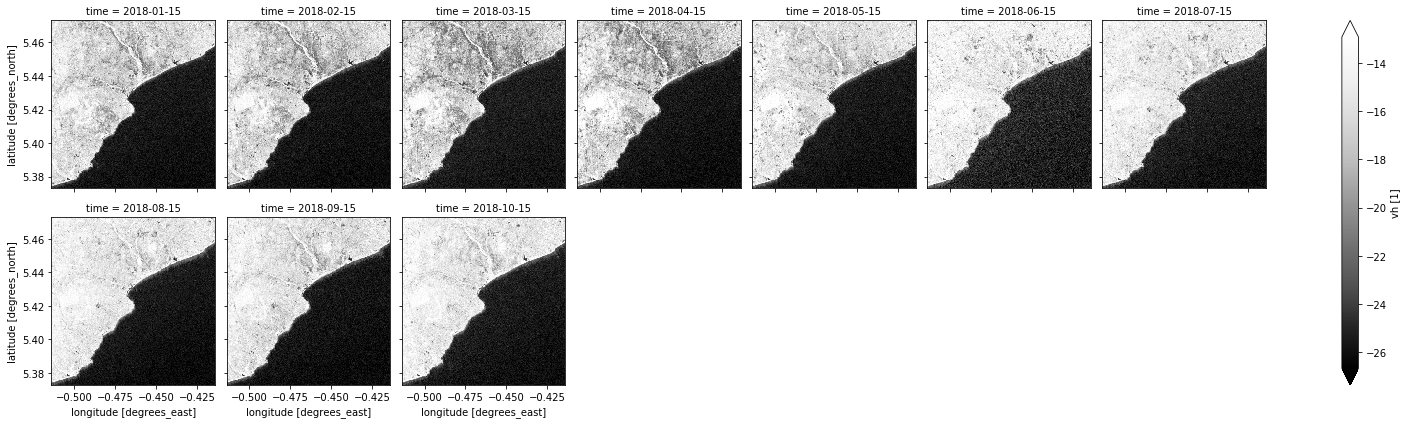

In [9]:
# Plot all VH observations for the year
ds_s1.vh.plot(cmap="Greys_r", robust=True, col="time", col_wrap=7)
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** Feb 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index]()